## Dependencias

In [28]:
import pandas as pd
import json #JSON = Java Script Object Notation
from sqlalchemy import create_engine
from sqlalchemy.types import VARCHAR,FLOAT,INTEGER,DATE,CHAR,DATETIME
import os

pd.set_option('display.max_columns',None)

## Credenciales

In [3]:
creds = json.load(open('credenciales_local.json','rb'))

## Crear conexión a base de datos

In [4]:
url = f"mysql+pymysql://{creds['user']}:{creds['password']}@{creds['servidor']}/{creds['base_de_datos']}"
cnx = create_engine(url,encoding='utf8')
cnx = cnx.connect()

In [5]:
cnx.closed

False

## Lectura y limpieza de datos

In [6]:
ruta = '/home/jose/Documentos/bd/chicago/'

In [7]:
listaArchivos = [os.path.join(ruta,arch) for arch in os.listdir(ruta) if 'csv' in arch]

## Cargar datos al servidor local

In [49]:
def cargarDatos(archivo:str):
    df  = pd.read_csv(archivo,dtype=str)
    for fh in ['trip_start_timestamp','trip_end_timestamp']:
        df[fh] = df[fh].fillna('9999-12-31').map(lambda x:x.split('-')).map(lambda x:[x[0],"%02d"%int(x[1]),x[2]]).map(lambda x:'-'.join(x))
        df[fh] = pd.to_datetime(df[fh],errors='coerce')    

    campos = dict(zip(df.columns,
                      [INTEGER]+[DATETIME]*2+[INTEGER,FLOAT]+4*[INTEGER]+[FLOAT]*5+[VARCHAR(80)]+[INTEGER]*5))

    df.sample(10000).to_sql(con=cnx,
                 name='viajes',
                 chunksize=1000,
                 if_exists='append',
                 index=False,
                 dtype=campos)

In [50]:
for archivo in listaArchivos:
    print(f"cargando el archivo {archivo} a la base de datos local..l")
    cargarDatos(archivo)

cargando el archivo /home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_08.csv a la base de datos local..l
cargando el archivo /home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_02.csv a la base de datos local..l
cargando el archivo /home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_06.csv a la base de datos local..l
cargando el archivo /home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_09.csv a la base de datos local..l
cargando el archivo /home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_03.csv a la base de datos local..l
cargando el archivo /home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_11.csv a la base de datos local..l
cargando el archivo /home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_07.csv a la base de datos local..l
cargando el archivo /home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_12.csv a la base de datos local..l
cargando el archivo /home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_05.csv a la base de datos l

## Cargar catálogos al servidor local

In [56]:
cat = json.load(open(os.path.join(ruta,'column_remapping.json'),'rb'))

In [59]:
cat.keys()

dict_keys(['taxi_id', 'company', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [ ]:
for k in cat.keys():
    aux = pd.Series(cat[k]).to_frame()
    aux.columns = [k]
    aux[f'{k}_clave'] = aux.index.astype(int)
    k = k.split('_')
    k = "".join(k[:1]+[w.capitalize() for w in k[1:]])
    aux.to_sql(con=cnx,
                 name=k,
                 chunksize=1000,
                 if_exists='replace',
                 index=False)

In [80]:
query = """
    select
        mes,
        round((actual-anterior)/ anterior, 2) as tasa_crec
    from
        (
        select
            mes,
            ingreso_total as actual,
            LAG(ingreso_total, 1) over (
            order by mes) as anterior
        from
            (
            SELECT
                DATE_FORMAT(trip_start_timestamp, '%%Y-%%m') AS mes,
                round(SUM(trip_total), 2) AS ingreso_total
            FROM
                taxis.viajes
            GROUP BY
                mes
            order by
                mes) as ingresos) as comparativo;
"""

<AxesSubplot:xlabel='mes'>

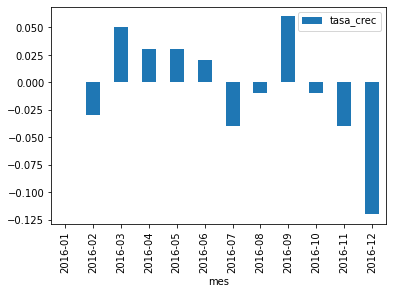

In [83]:
pd.read_sql(con=cnx,sql=query).set_index('mes').plot(kind='bar')